# Store Sales Time Series Forecasting Pre-processing and Modeling

In [1]:
#import base packages
import pandas as pd
import numpy as np
import os
import gc
import warnings

#PACF-ACF
import statsmodels.api as sm

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [2]:
#import data
train = pd.read_csv('cleaned_data/train.csv')
test= pd.read_csv('raw_data/test.csv')
stores= pd.read_csv('cleaned_data/stores.csv')
transaction = pd.read_csv('cleaned_data/transaction.csv')
oil = pd.read_csv('cleaned_data/oil.csv')
holidays = pd.read_csv('cleaned_data/holidays_events.csv')

In [3]:
train['date'] = pd.to_datetime(train['date'])
train['day_of_week'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year

In [4]:
test['date'] = pd.to_datetime(test['date'])
test['day_of_week'] = test['date'].dt.dayofweek
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year

## Linear Regression

In [5]:
avg_sales = train.groupby('date').agg({'sales': 'mean'}).reset_index()
avg_sales['Time'] = np.arange(len(avg_sales.index))
avg_sales.head()

date       sales  Time
0 2013-01-01    1.705105     0
1 2013-01-02  336.790508     1
2 2013-01-03  245.391196     2
3 2013-01-04  240.637934     3
4 2013-01-05  324.066613     4

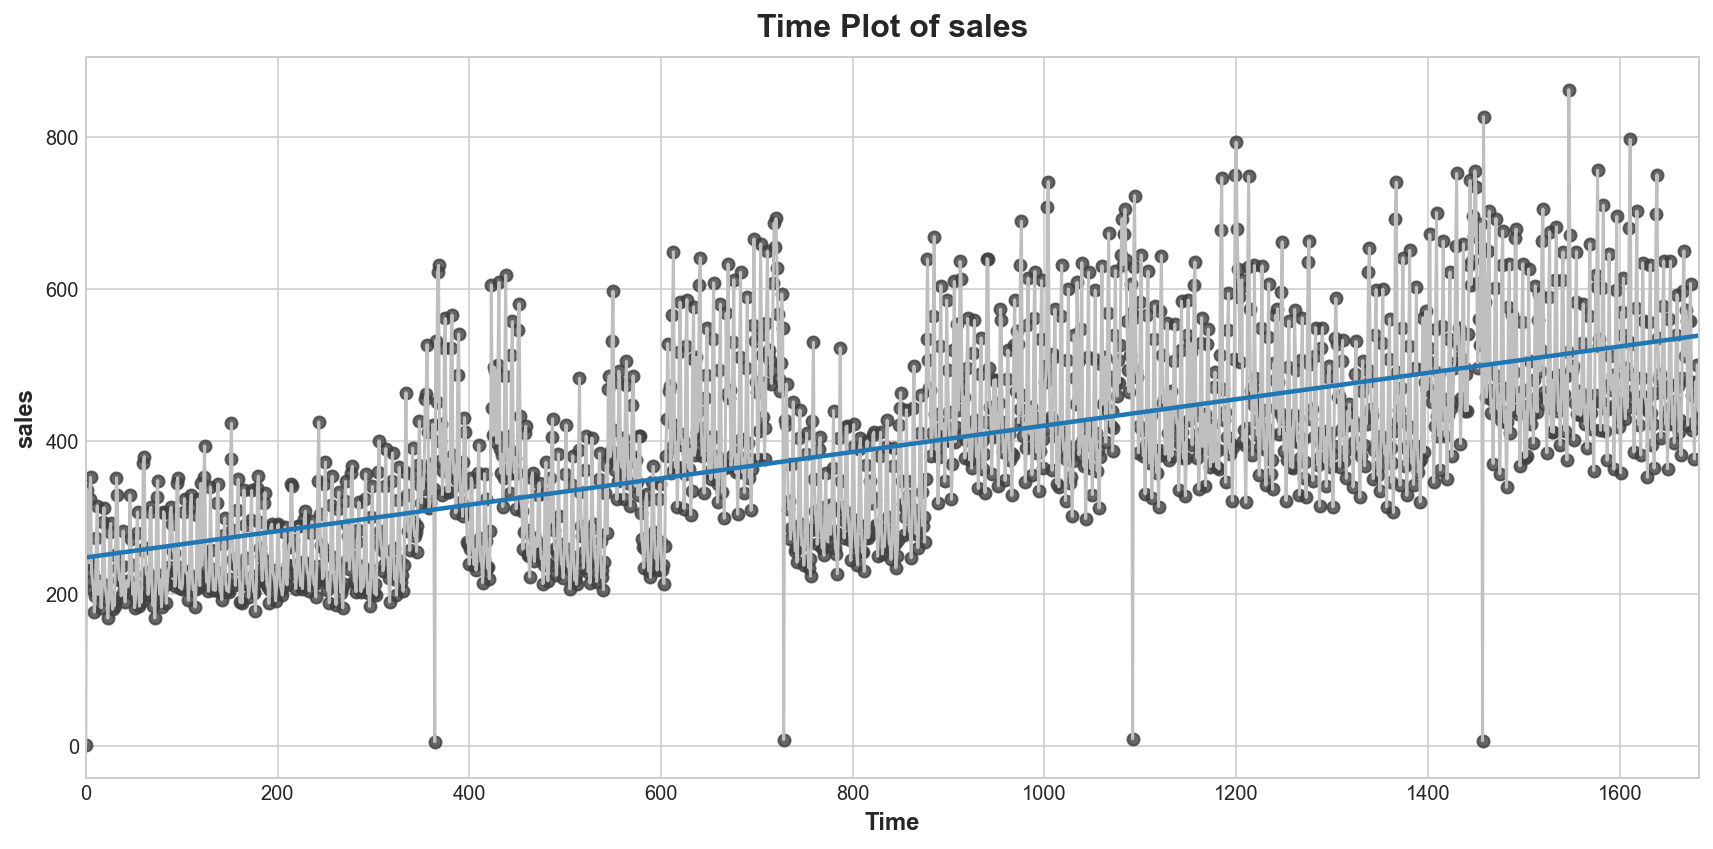

In [6]:
import seaborn as sns

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(12, 6),
    titlesize=18,
    titleweight='bold',
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

# Use it for the Lag_1 plot later.
plot_params = dict(
    color = '0.75',
    style = ".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

%config InlineBackend.figure_format = 'retina' # You can remove

fig, ax = plt.subplots()
ax.plot('Time', 'sales', data=avg_sales, color='0.75')
ax = sns.regplot(x='Time', y='sales', data=avg_sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of sales');

In [7]:
avg_sales['Lag_1'] = avg_sales['sales'].shift(1)
avg_sales = avg_sales.reindex(columns = ['date','sales', 'Lag_1','Time'])
avg_sales.head()

date       sales       Lag_1  Time
0 2013-01-01    1.705105         NaN     0
1 2013-01-02  336.790508    1.705105     1
2 2013-01-03  245.391196  336.790508     2
3 2013-01-04  240.637934  245.391196     3
4 2013-01-05  324.066613  240.637934     4

Text(0.5, 1.0, 'Lag Plot of sales')

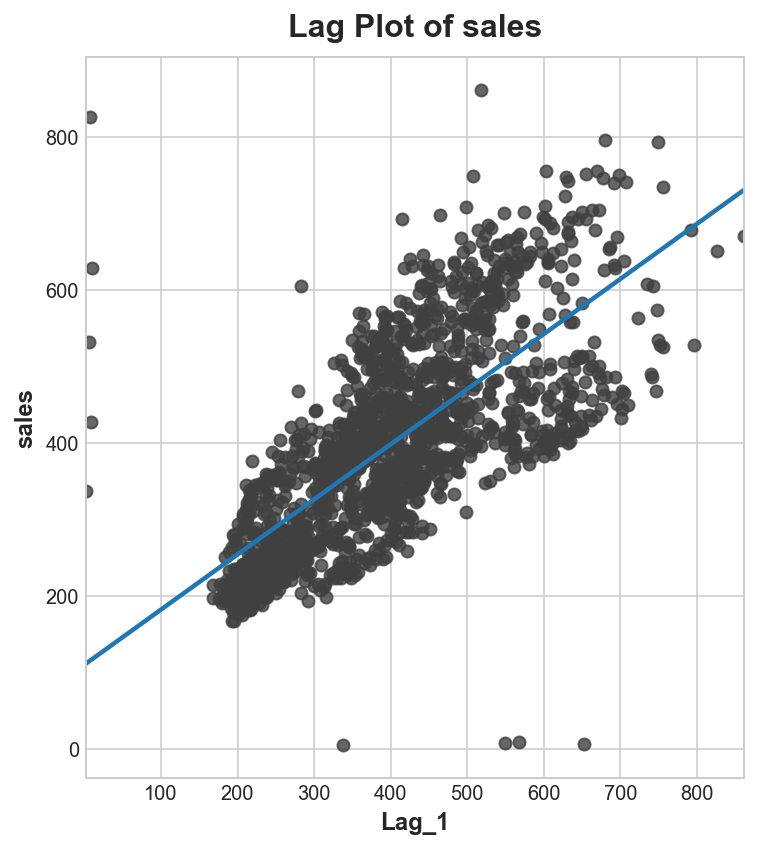

In [8]:
fig, ax = plt.subplots()
ax = sns.regplot(x = 'Lag_1', y = 'sales', data = avg_sales, ci = None, scatter_kws = dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of sales')

In [9]:
from sklearn.linear_model import LinearRegression

# Training data
X = avg_sales.loc[:, ['Time']] # features
y = avg_sales.loc[:, 'sales'] # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index = X.index)
y_pred

0       247.597029
1       247.770084
2       247.943140
3       248.116195
4       248.289251
           ...    
1679    538.156948
1680    538.330003
1681    538.503058
1682    538.676114
1683    538.849169
Length: 1684, dtype: float64

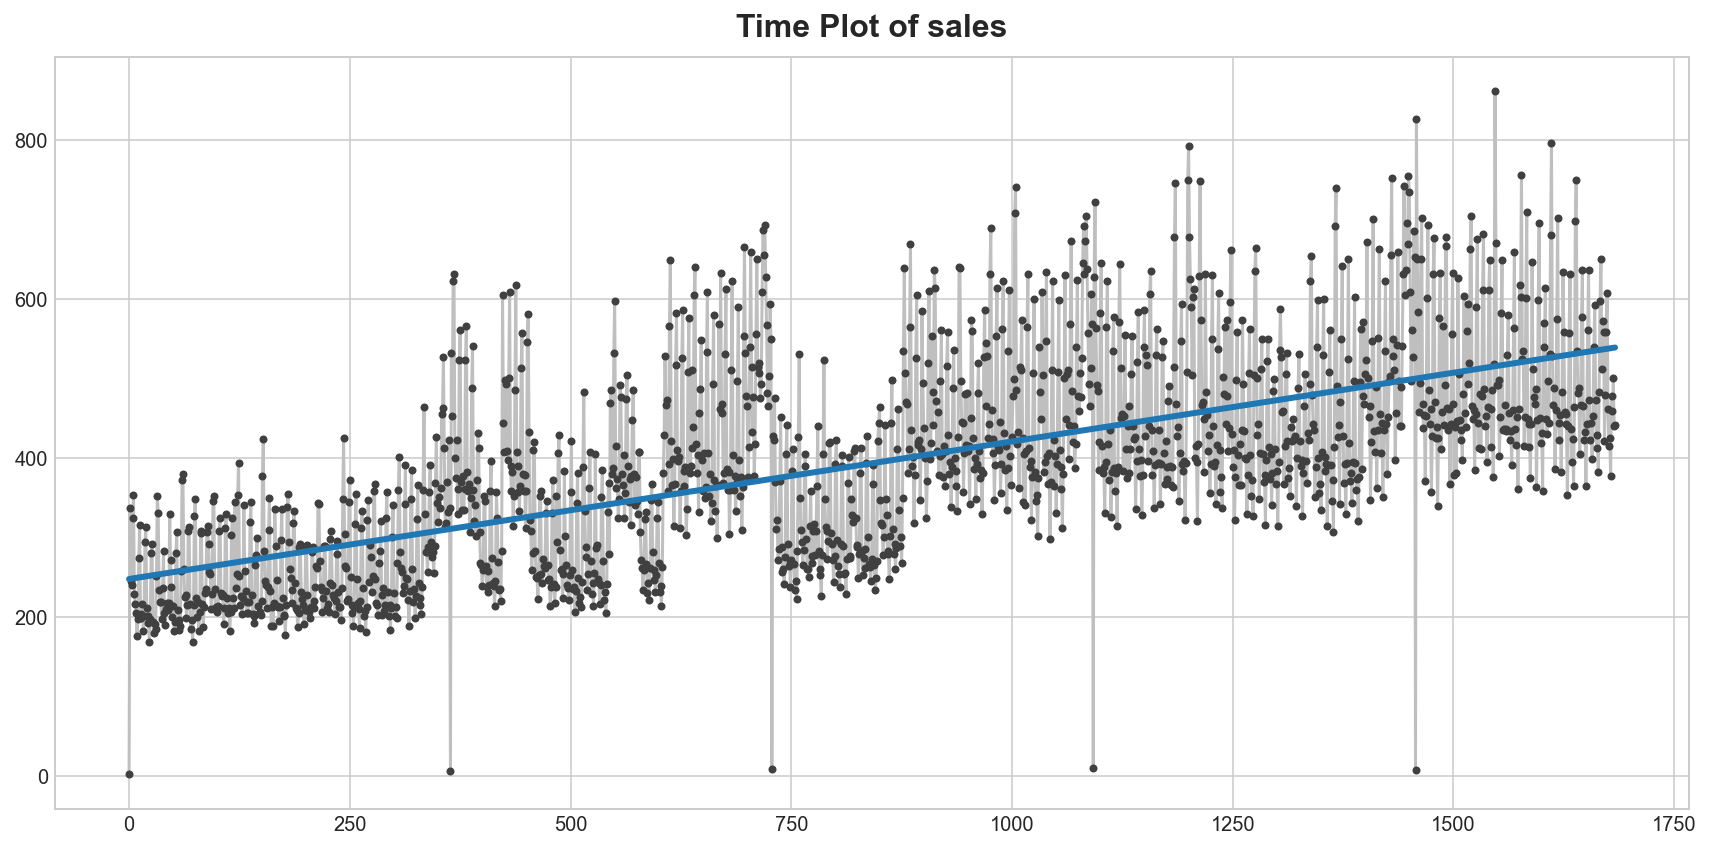

In [10]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth = 3)
ax.set_title('Time Plot of sales');

In [11]:
X = avg_sales.loc[:, ['Lag_1']]
X.dropna(inplace = True) # drop missing values in the feature set
y = avg_sales.loc[:, 'sales'] # create the target
y, X = y.align(X, join = 'inner') # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_pred

1       111.659200
2       352.855688
3       287.065914
4       283.644487
5       343.696952
           ...    
1679    381.613010
1680    454.462378
1681    440.414635
1682    470.809325
1683    427.214113
Length: 1683, dtype: float64

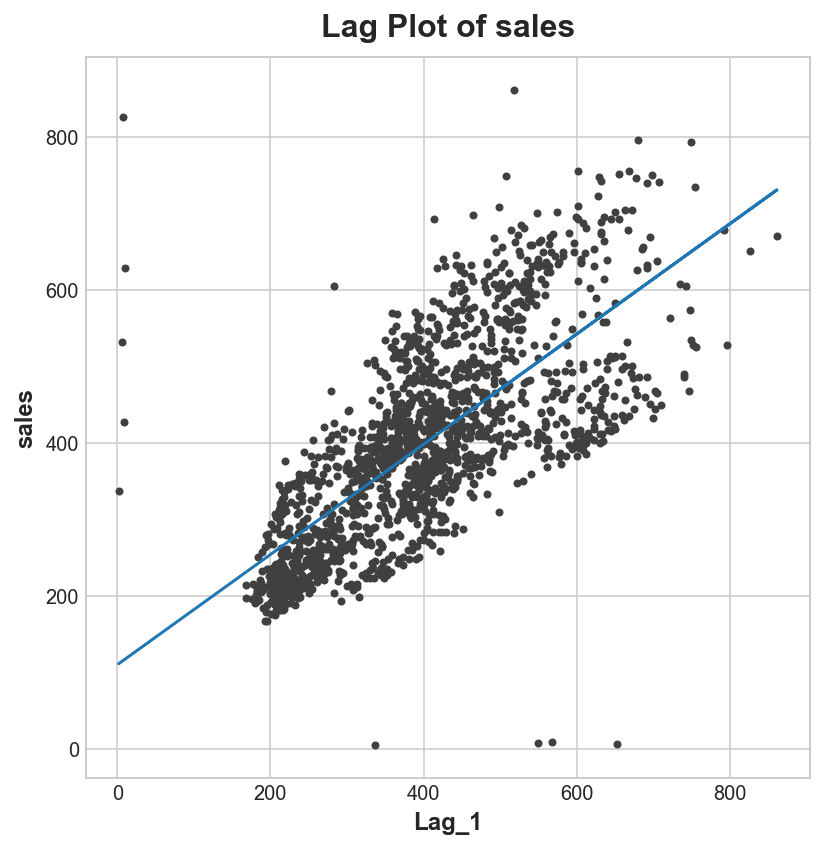

In [12]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('sales')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of sales');

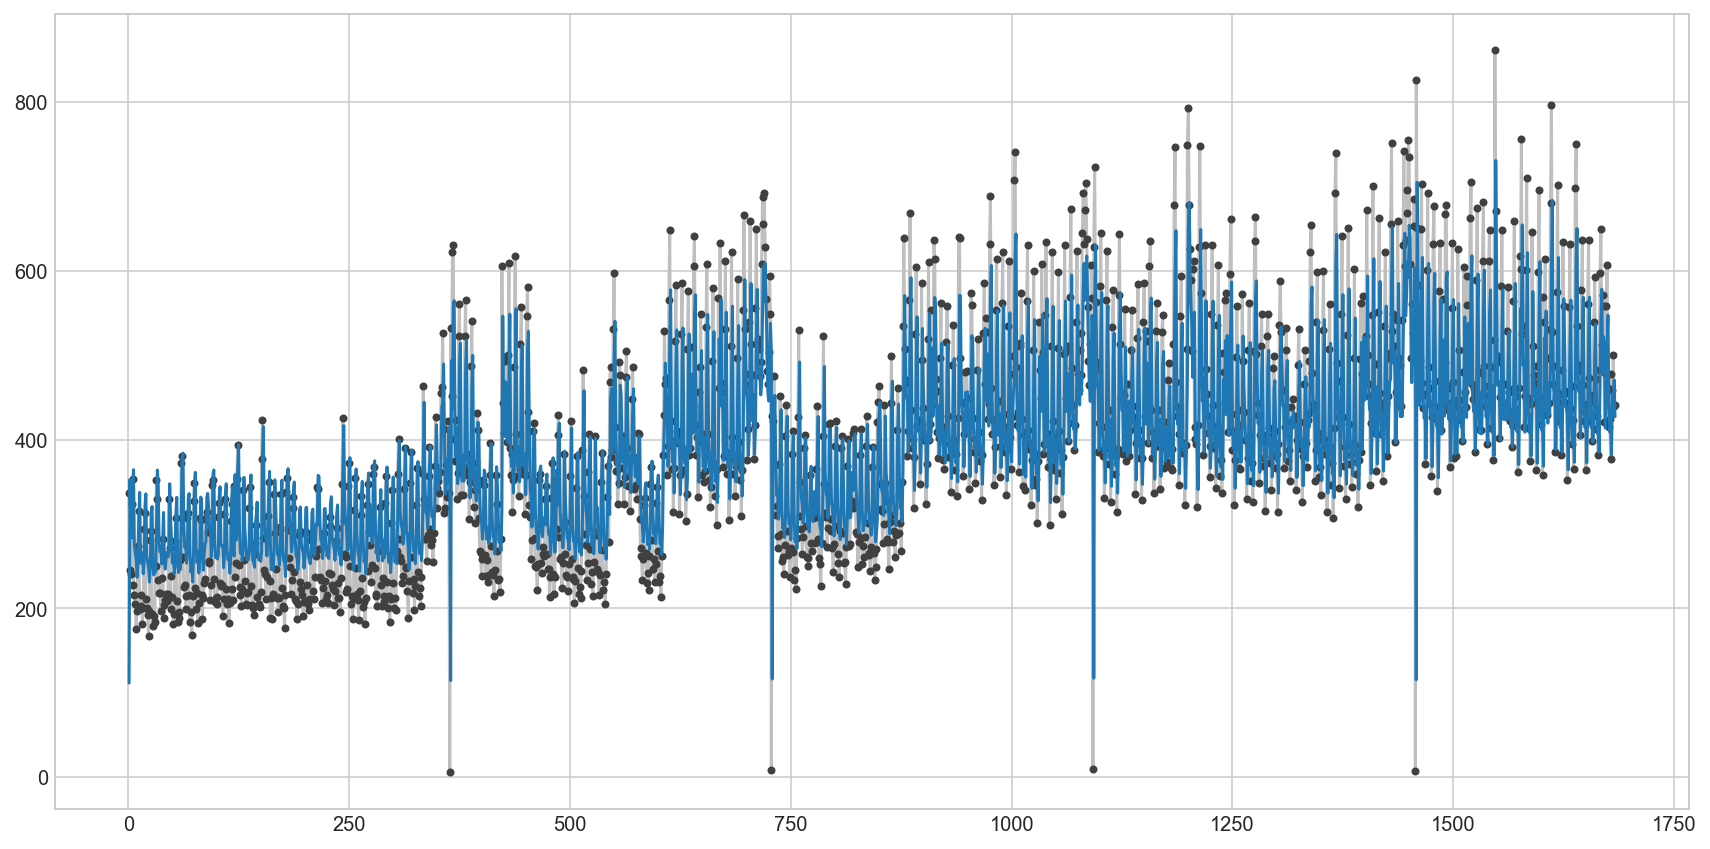

In [13]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

## Trend

In [14]:
from pathlib import Path
from warnings import simplefilter

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# Load the sales dataset
avg_sales = train.groupby('date').agg({'sales': 'mean'}).reset_index()
#avg_sales = avg_sales.set_index('date')
#avg_sales.index = pd.to_datetime(avg_sales.index)
avg_sales = avg_sales.set_index('date').to_period("D")
avg_sales.head()

sales
date                  
2013-01-01    1.705105
2013-01-02  336.790508
2013-01-03  245.391196
2013-01-04  240.637934
2013-01-05  324.066613

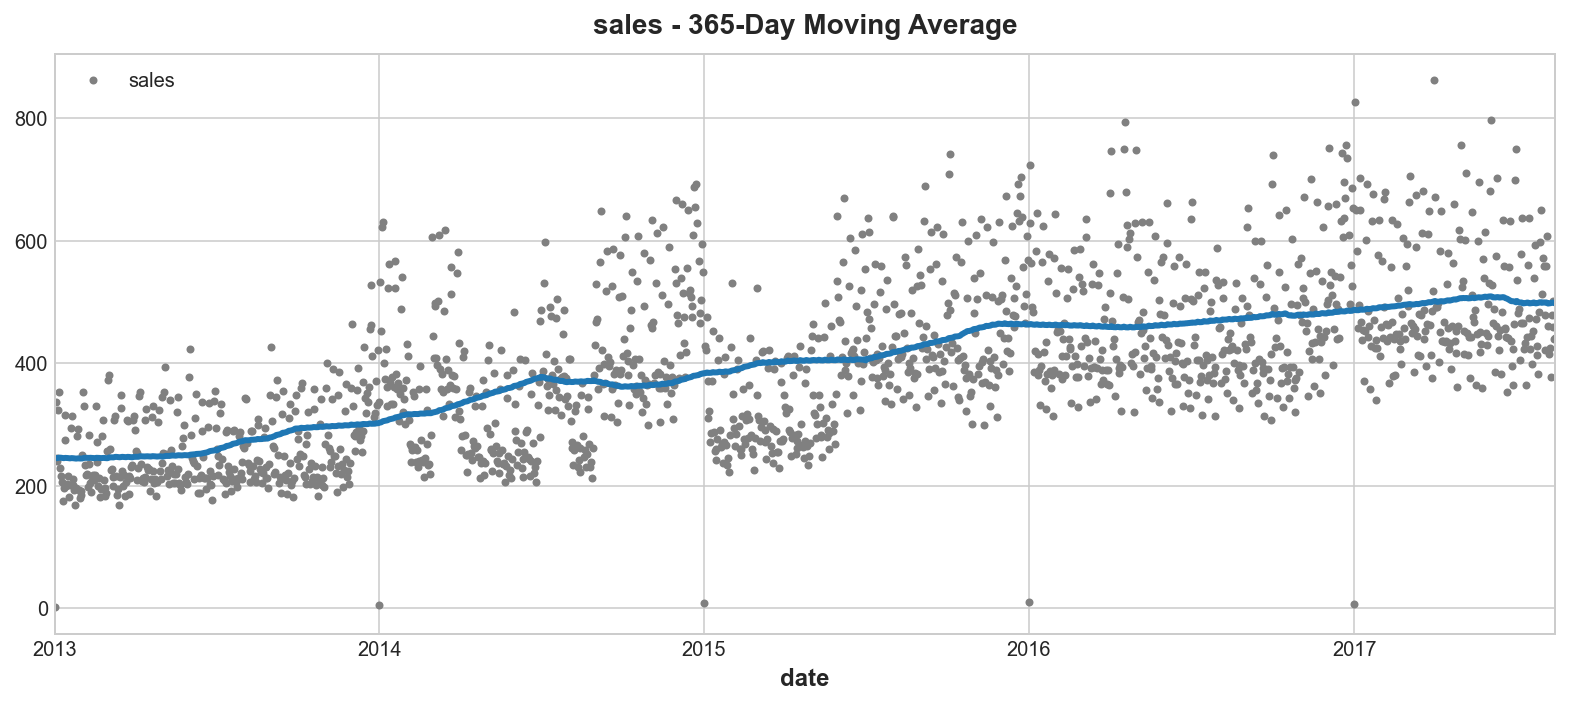

In [15]:
moving_average = avg_sales.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = avg_sales.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="sales - 365-Day Moving Average", legend=False,
);

In [16]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=avg_sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

const  trend
date                    
2013-01-01    1.0    1.0
2013-01-02    1.0    2.0
2013-01-03    1.0    3.0
2013-01-04    1.0    4.0
2013-01-05    1.0    5.0

In [17]:
y = avg_sales["sales"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

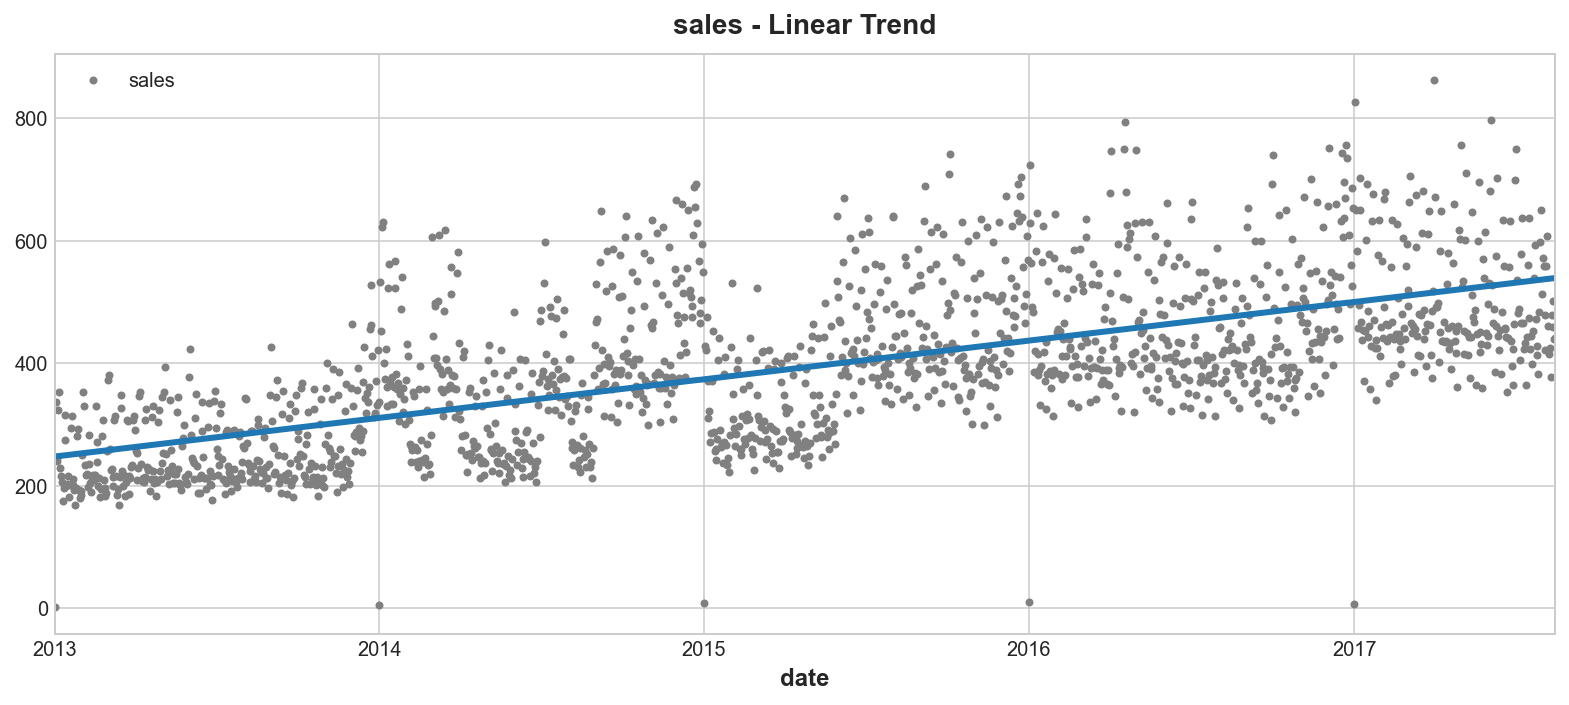

In [18]:
ax = avg_sales.plot(style=".", color="0.5", title="sales - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")


In [19]:
X = dp.out_of_sample(steps=180)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2017-08-16    539.022224
2017-08-17    539.195280
2017-08-18    539.368335
2017-08-19    539.541390
2017-08-20    539.714446
Freq: D, dtype: float64

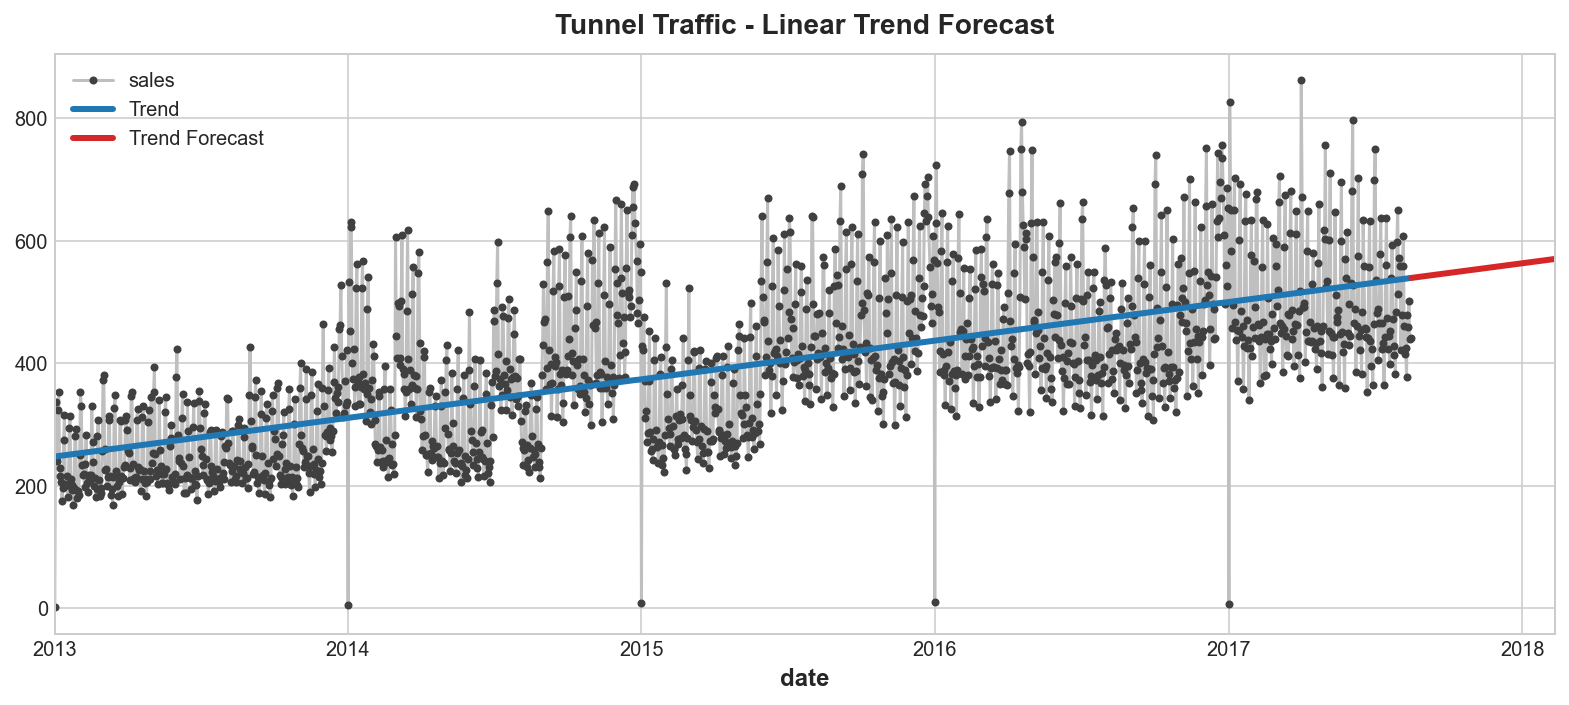

In [20]:
ax = avg_sales["2013-01":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2013-01":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

## Seasonality 

In [21]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

# Load the sales dataset
avg_sales = train.groupby('date').agg({'sales': 'mean'}).reset_index()
avg_sales = avg_sales.set_index('date').to_period("D")
avg_sales.head()

sales
date                  
2013-01-01    1.705105
2013-01-02  336.790508
2013-01-03  245.391196
2013-01-04  240.637934
2013-01-05  324.066613

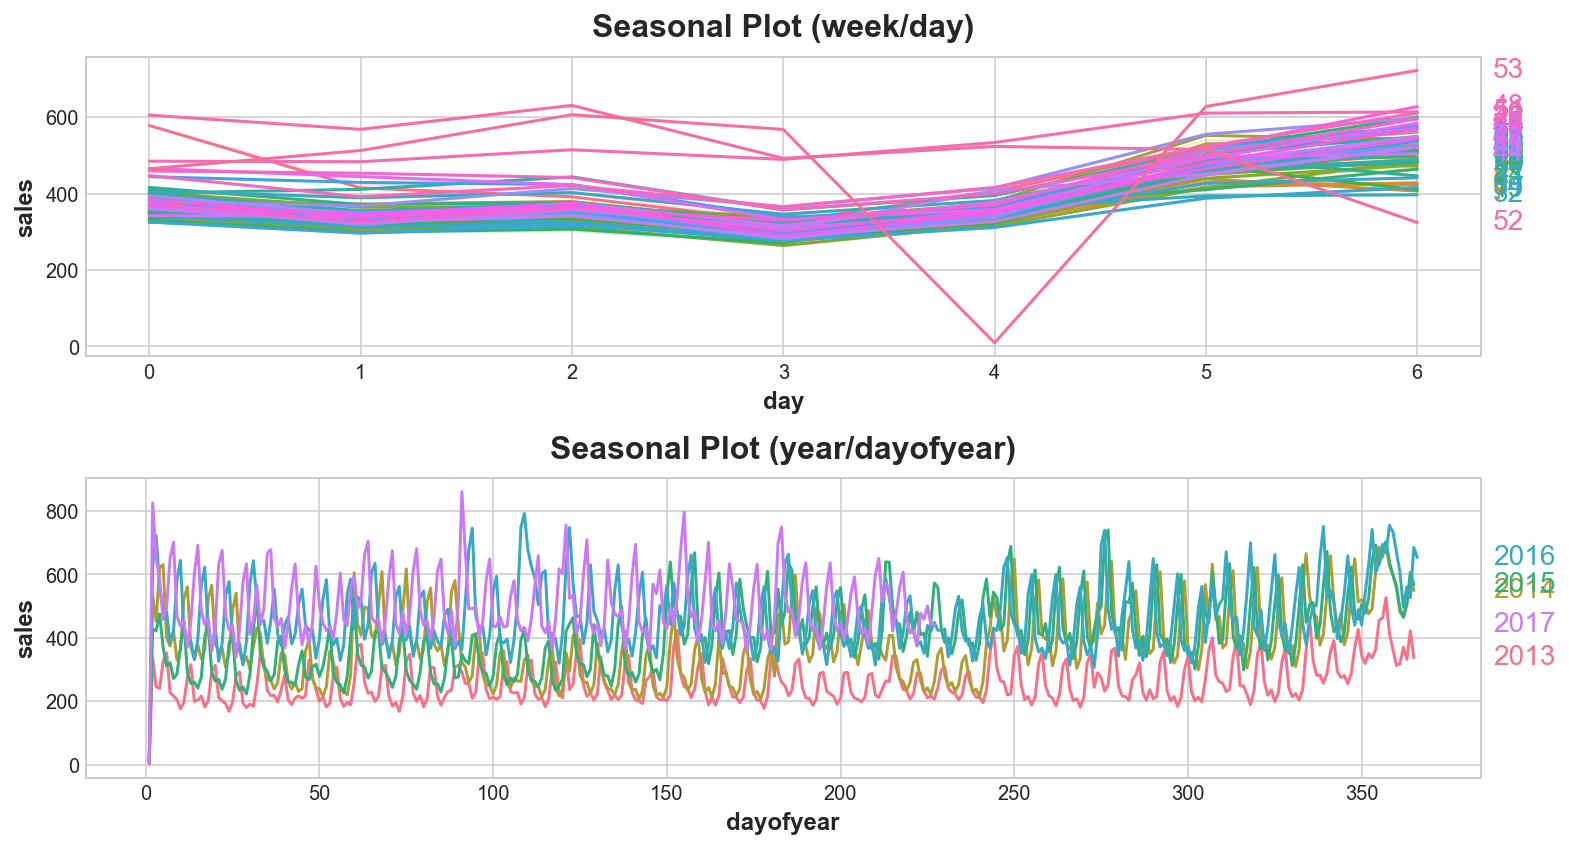

In [22]:
X = avg_sales.copy()

# days within a week
X['day'] = X.index.dayofweek # the x-axis (freq)
X['week'] = X.index.week # the seasonal period (period)

# days within a year
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);

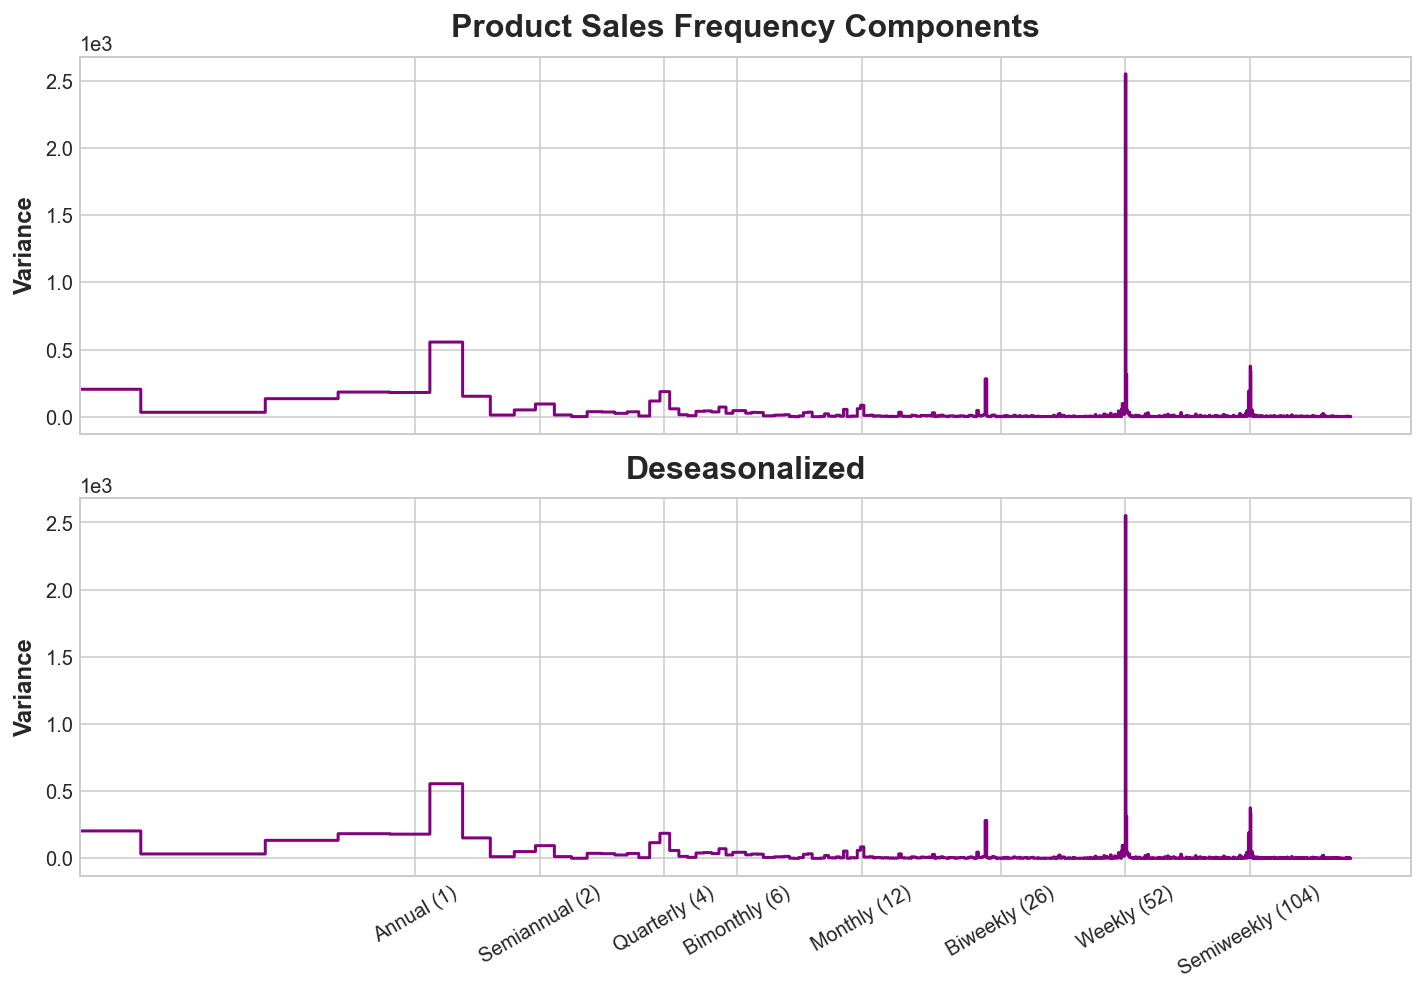

In [23]:
#plot_periodogram(avg_sales.sales);

y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

Periodogram suggest a strong weekly seasonaliy. Removing from a series its trend or seasons is called detrending or deseasonalizing the series. The periodogram for the deseasonalized series lacks any large values. By comparing it to the periodogram for the original series, we can see that our model was able to capture the seasonal variation in Average Sales.

In [24]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=avg_sales.index,
    constant=True,   # dummy feature for bias (y-intercept)
    order=1,         # trend ( order 1 means linear)
    seasonal=True,   # weekly seasonality (indicators)
    additional_terms=[fourier], # annual seasonality
    drop=True,       # drop terms to avoid collinearity
)

X = dp.in_sample() # create features for dates in tunnel.index
#X.head()

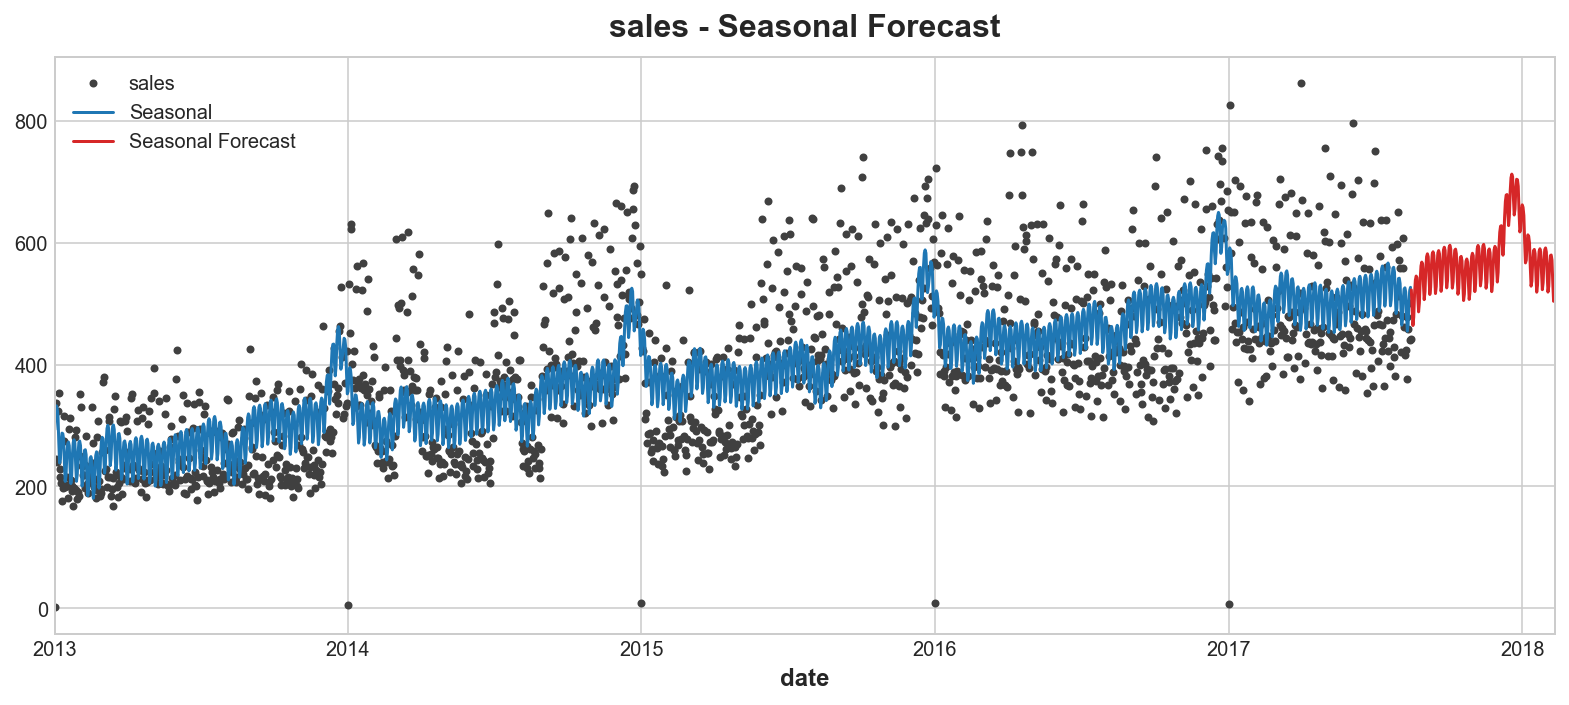

In [25]:
y = avg_sales["sales"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=180)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

In [26]:
comp_dir = Path('cleaned_data')

holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

description
date                                              
2017-01-01                      Primer dia del ano
2017-01-02             Traslado Primer dia del ano
2017-02-27                                Carnaval
2017-02-28                                Carnaval
2017-04-01           Provincializacion de Cotopaxi
2017-04-14                           Viernes Santo
2017-05-01                         Dia del Trabajo
2017-05-13                       Dia de la Madre-1
2017-05-14                         Dia de la Madre
2017-05-24                    Batalla de Pichincha
2017-05-26           Traslado Batalla de Pichincha
2017-06-25           Provincializacion de Imbabura
2017-08-10           Primer Grito de Independencia
2017-08-11  Traslado Primer Grito de Independencia

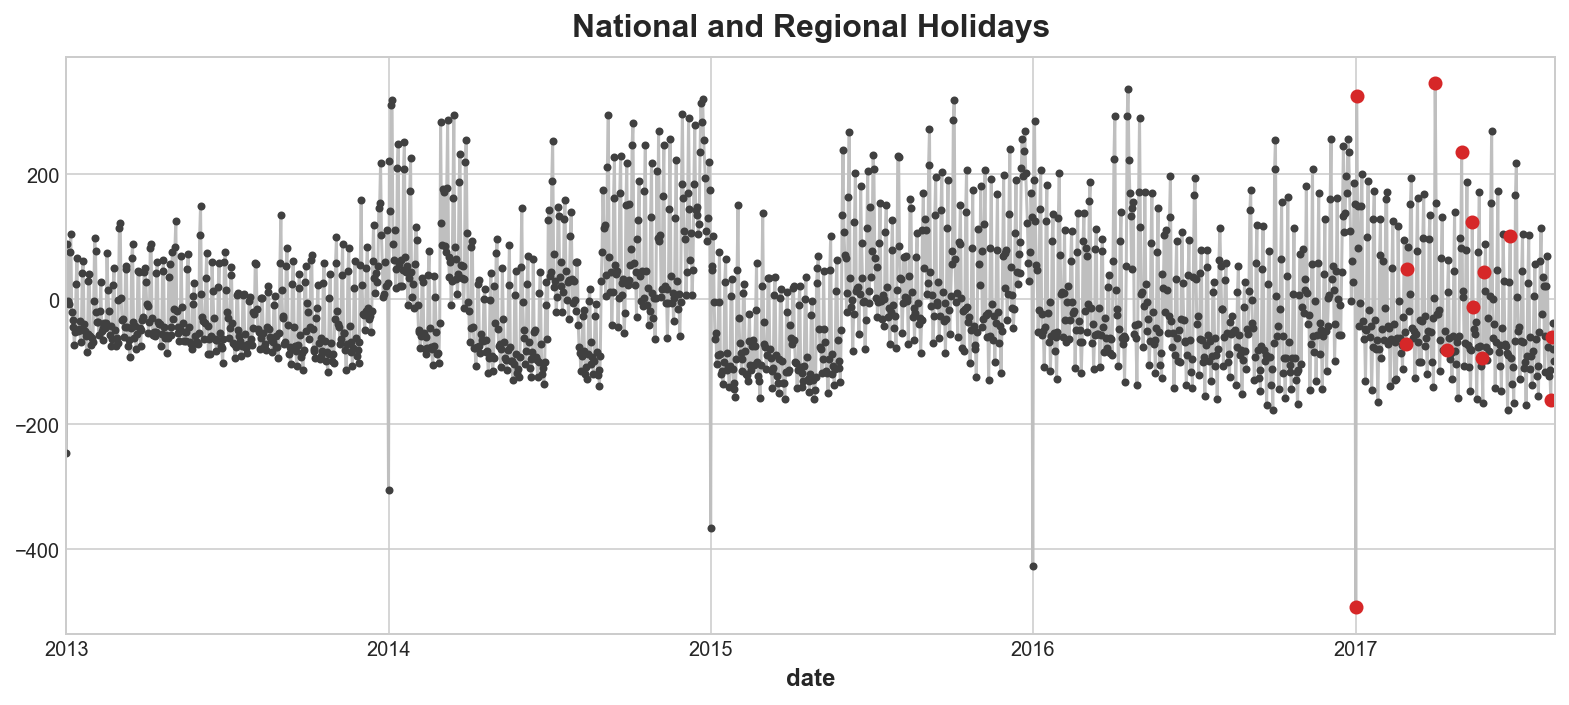

In [27]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

In [28]:
# Scikit-learn solution
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

X_holidays = pd.DataFrame(
    ohe.fit_transform(holidays),
    index=holidays.index,
    columns=holidays.description.unique(),
)


# Pandas solution
X_holidays = pd.get_dummies(holidays)


# Join to training data
X2 = X.join(X_holidays, on='date').fillna(0.0)

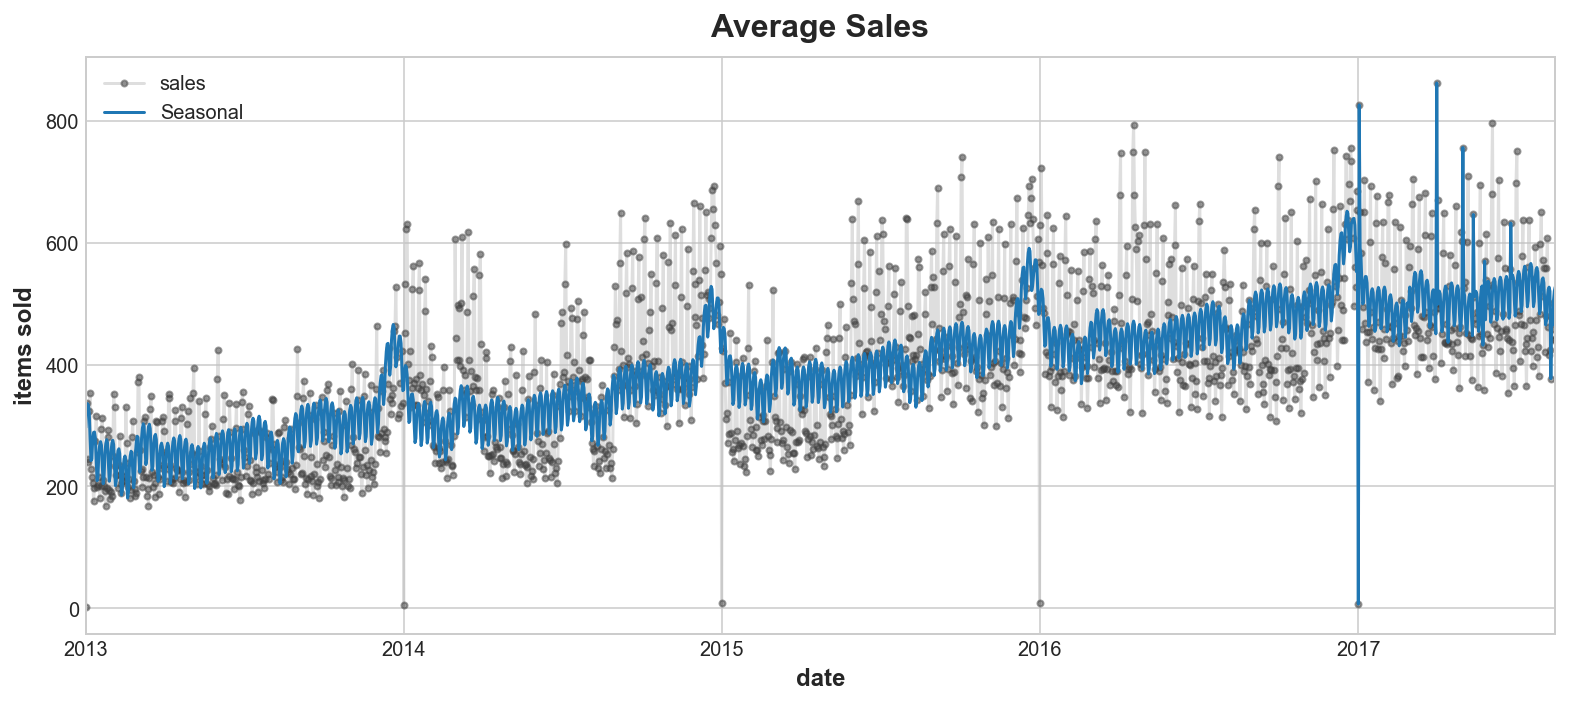

In [29]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

## Time Series as Features

In [30]:
store_sales = train.copy()
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

produce_sales = family_sales.loc(axis=1)[:, 'PRODUCE']

In [31]:
store_sales.head()

id  sales  onpromotion  day_of_week  month  \
store_nbr family     date                                                       
1         AUTOMOTIVE 2013-01-01     0    0.0          0.0            1      1   
                     2013-01-02  1782    2.0          0.0            2      1   
                     2013-01-03  3564    3.0          0.0            3      1   
                     2013-01-04  5346    3.0          0.0            4      1   
                     2013-01-05  7128    5.0          0.0            5      1   

                                 year  
store_nbr family     date              
1         AUTOMOTIVE 2013-01-01  2013  
                     2013-01-02  2013  
                     2013-01-03  2013  
                     2013-01-04  2013  
                     2013-01-05  2013

In [32]:
produce_sales.head()

sales onpromotion
family          PRODUCE     PRODUCE
date                               
2017-01-01    31.751774    0.132075
2017-01-02  3473.830734    5.735849
2017-01-03  3458.608053   57.358491
2017-01-04  3532.871502  103.188679
2017-01-05  2108.360340    5.113208

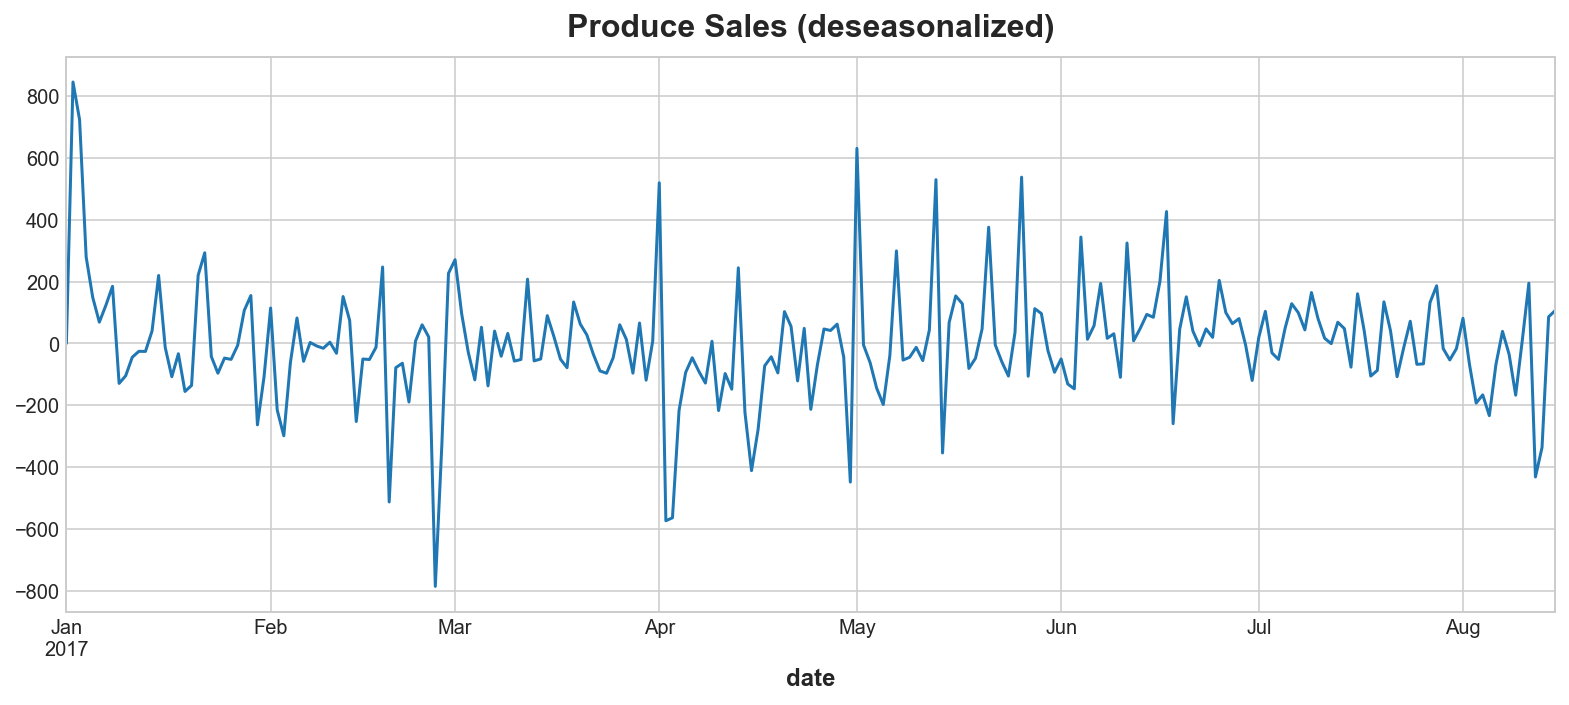

In [33]:
y = produce_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Produce Sales (deseasonalized)");

By lagging a time series, we can make its past values appear contemporaneous with the values we are trying to predict (in the same row, in other words). This makes lagged series useful as features for modeling serial dependence. To forecast series, we could use y_lag_1 and y_lag_2 as features to predict the target y.

## Lag Plot
A lag plot of a time series shows its values plotted against its lags. Serial dependence in a time series will often become apparent by looking at a lag plot. The most commonly used measure of serial dependence is known as autocorrelation, which is simply the correlation a time series has with one of its lags. The partial autocorrelation tells you the correlation of a lag accounting for all of the previous lags -- the amount of "new" correlation the lag contributes, so to speak. Plotting the partial autocorrelation can help you choose which lag features to use.

In [34]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(alpha=0.75,s=3)
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_, y=y_, scatter_kws=scatter_kws, line_kws=line_kws, lowess=True, ax=ax, **kwargs)
    at = AnchoredText(f"{corr:.2f}",prop=dict(size="large"), frameon=True, loc="upper left")
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2 + 10, nrows * 2 + 5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

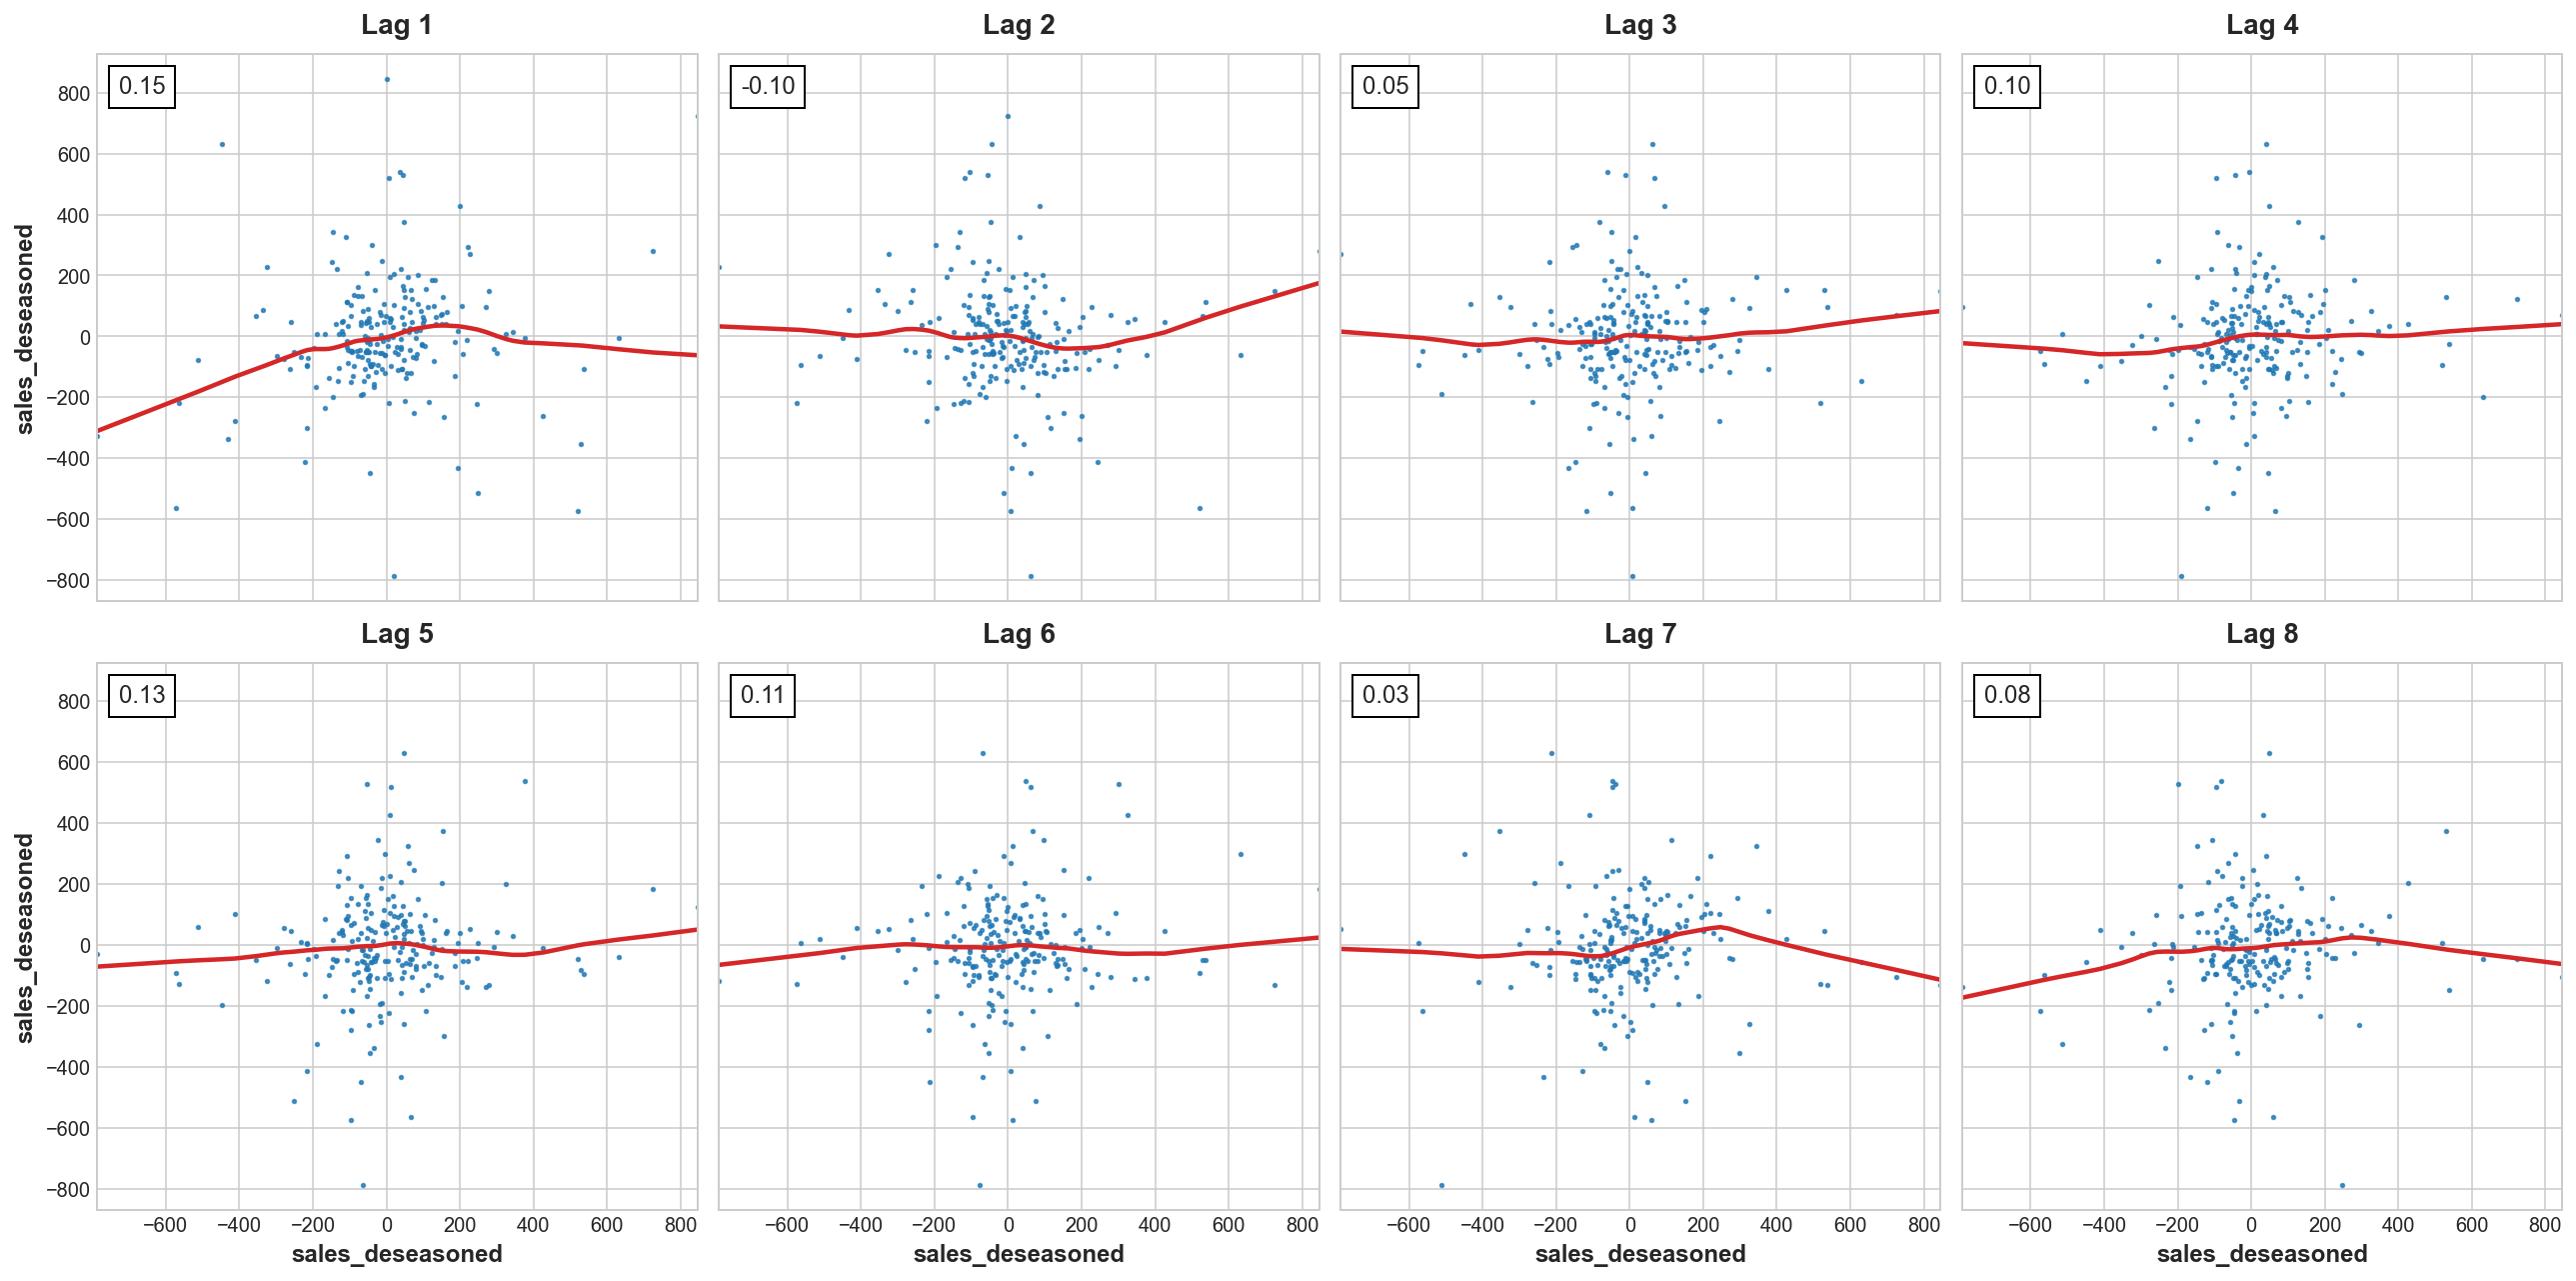

In [35]:
_ = plot_lags(y_deseason, lags=8, nrows=2)

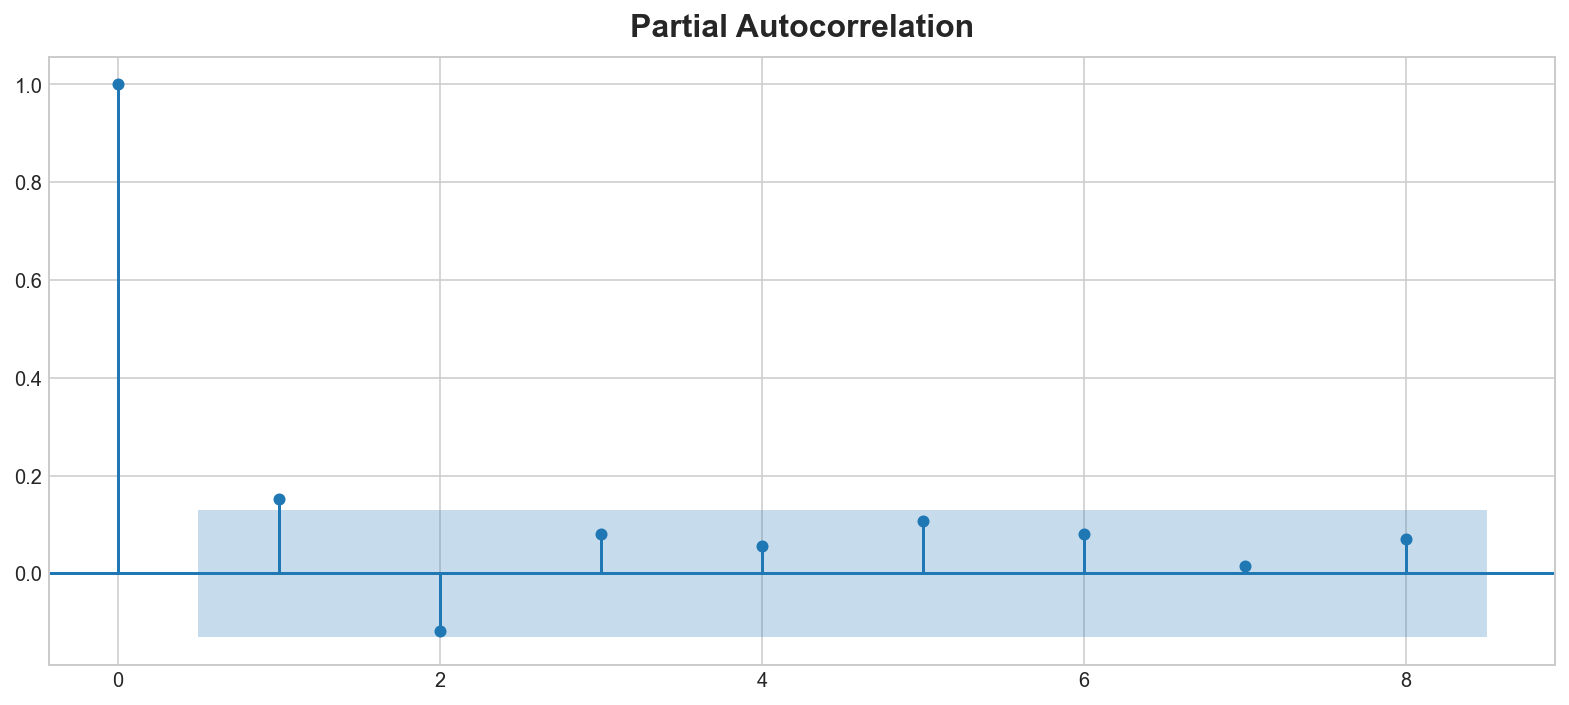

In [36]:
from statsmodels.graphics.tsaplots import plot_pacf
_ = plot_pacf(y_deseason, lags=8)

## Lags Forecasting

In [37]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [38]:
X = make_lags(y_deseason, lags=4)
X = X.fillna(0.0)

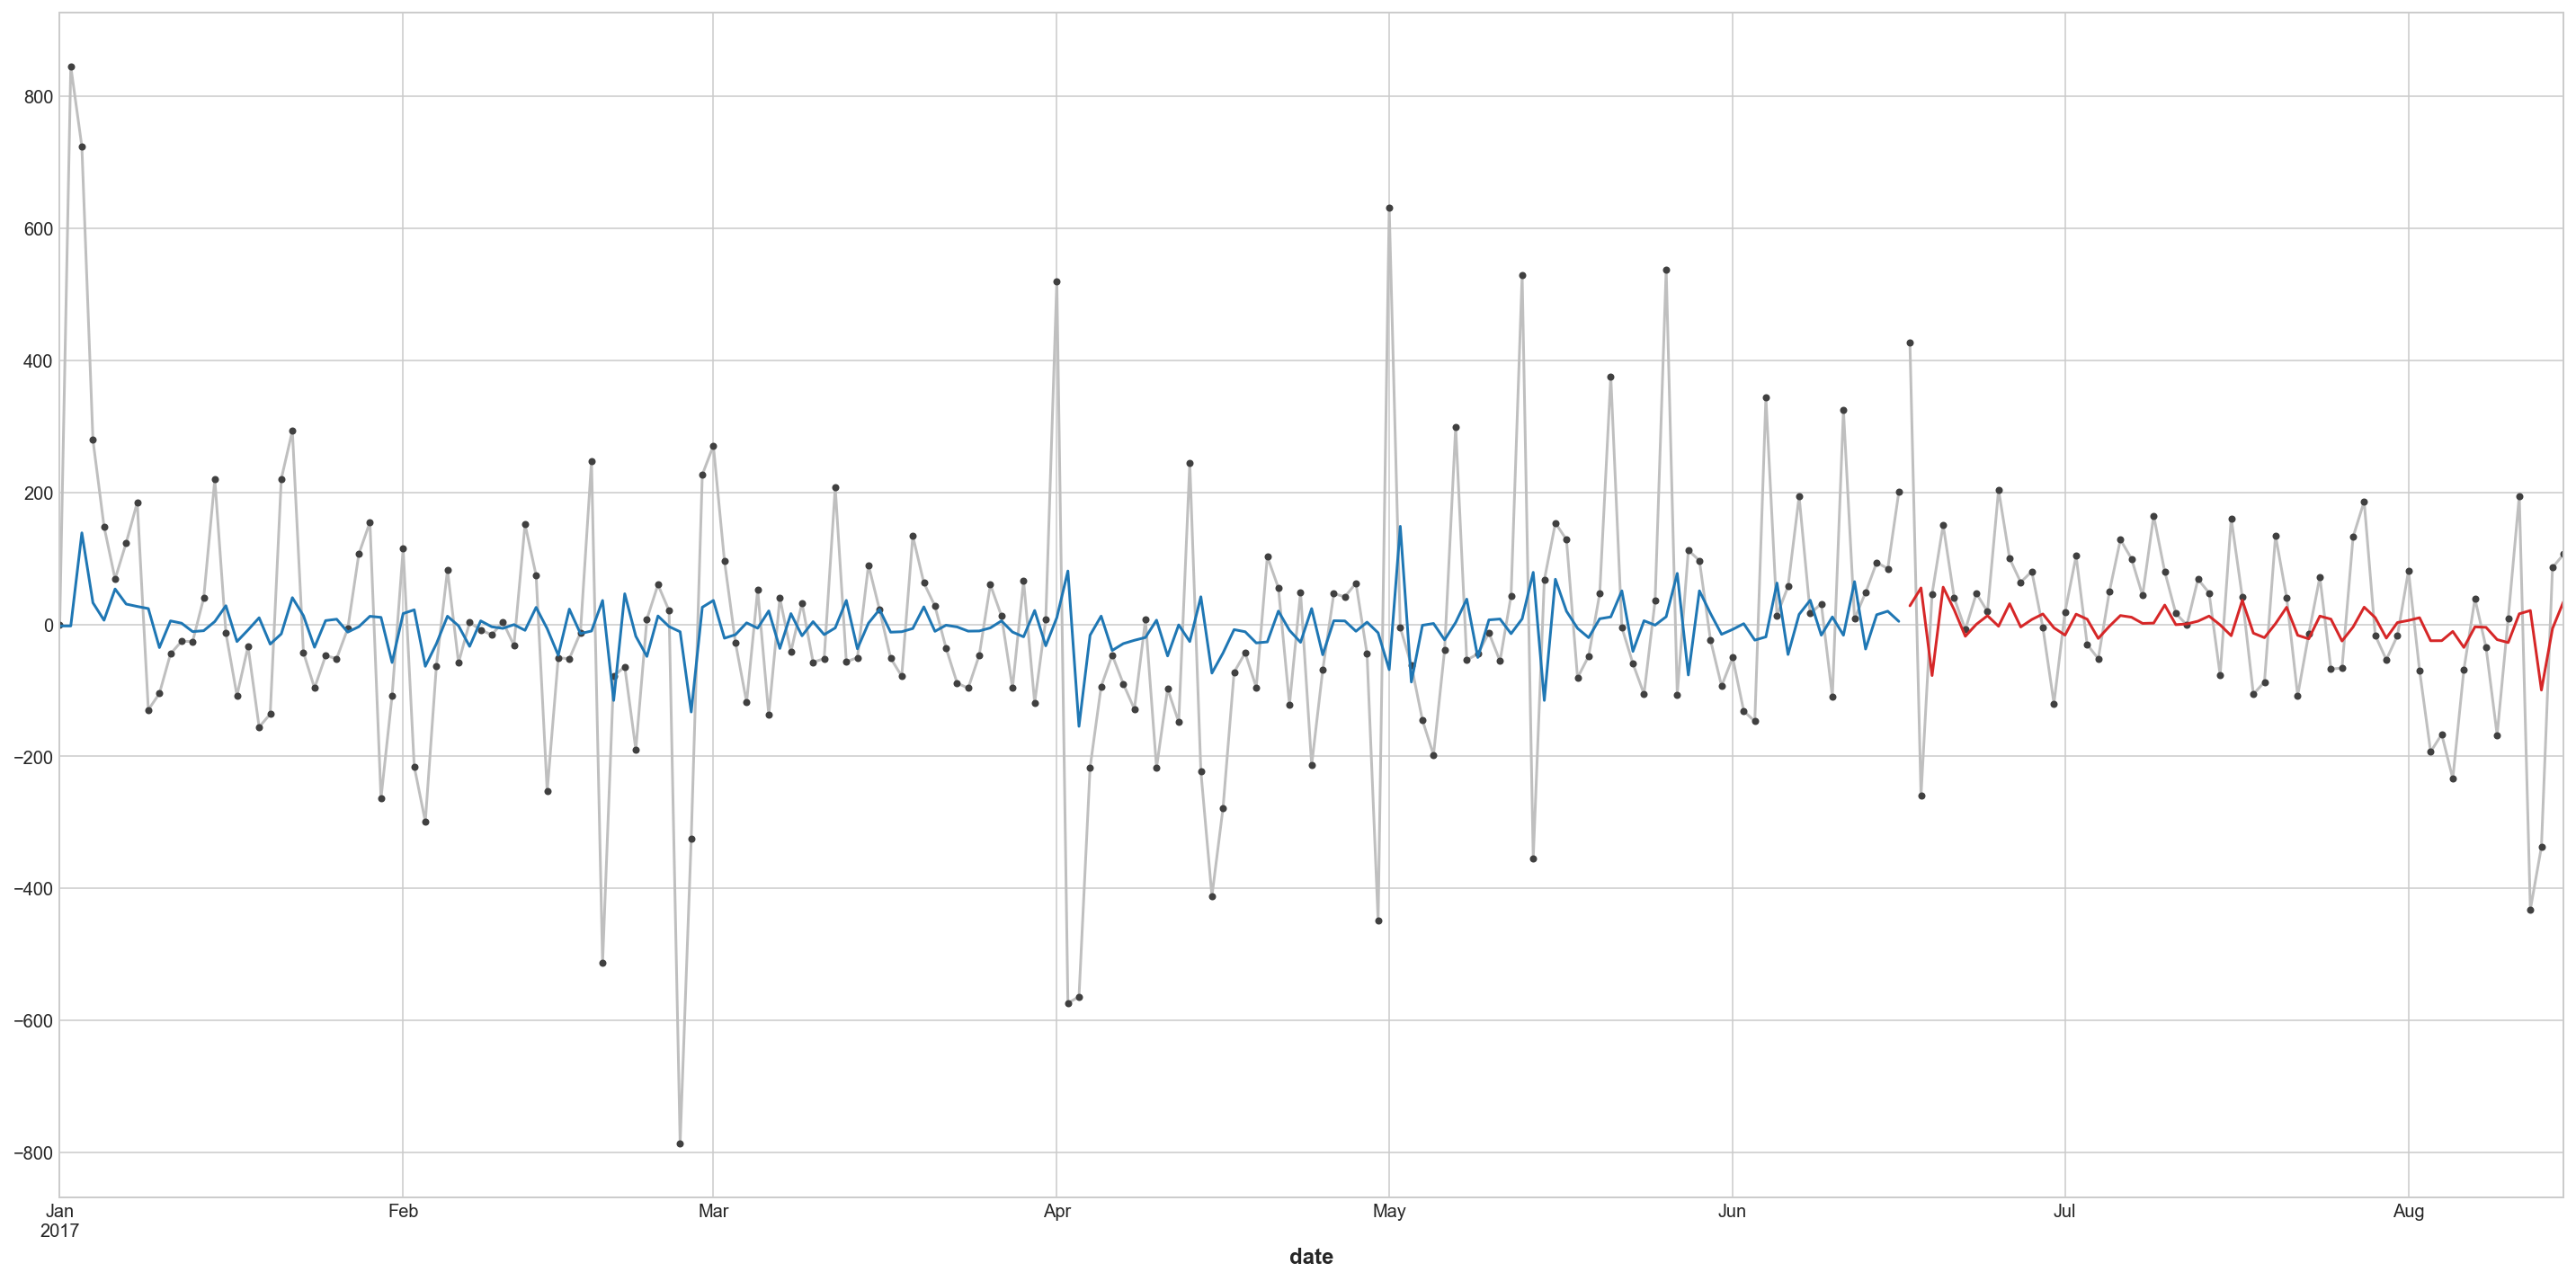

In [39]:
#build a plot with predictions
# Create target series and data splits
from sklearn.model_selection import train_test_split
y = y_deseason.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax = y_train.plot(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", ax=ax)
ax = y_test.plot(color="0.75",style=".-",markeredgecolor="0.25", markerfacecolor="0.25", ax=ax)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')
plt.show()

## Hybrid Models
Linear regression excels at extrapolating trends, but can't learn interactions. XGBoost excels at learning interactions, but can't extrapolate trends. Here we'll learn how to create "hybrid" forecasters that combine complementary learning algorithms and let the strengths of one make up for the weakness of the other.

In [40]:
store_sales = train.copy()
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

In [41]:
# create Boosted Hybrid class
# we'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

In [42]:
def fit(self, X_1, X_2, y):
    # train model_1
    self.model_1.fit(X_1, y)

    # make predictions
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=y.columns,
    )

    # compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # train model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

In [43]:
def predict(self, X_1, X_2):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(X_2)

    return y_pred.unstack()


# Add method to class
BoostedHybrid.predict = predict

In [44]:
#set data for training
# Target series
from sklearn.preprocessing import LabelEncoder
y = family_sales.loc[:, 'sales']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

In [45]:
# train model
#Create model
from xgboost import XGBRegressor
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor())

model.fit(X_1, X_2, y)

y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)

In [46]:
# Boosted Hybrid
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

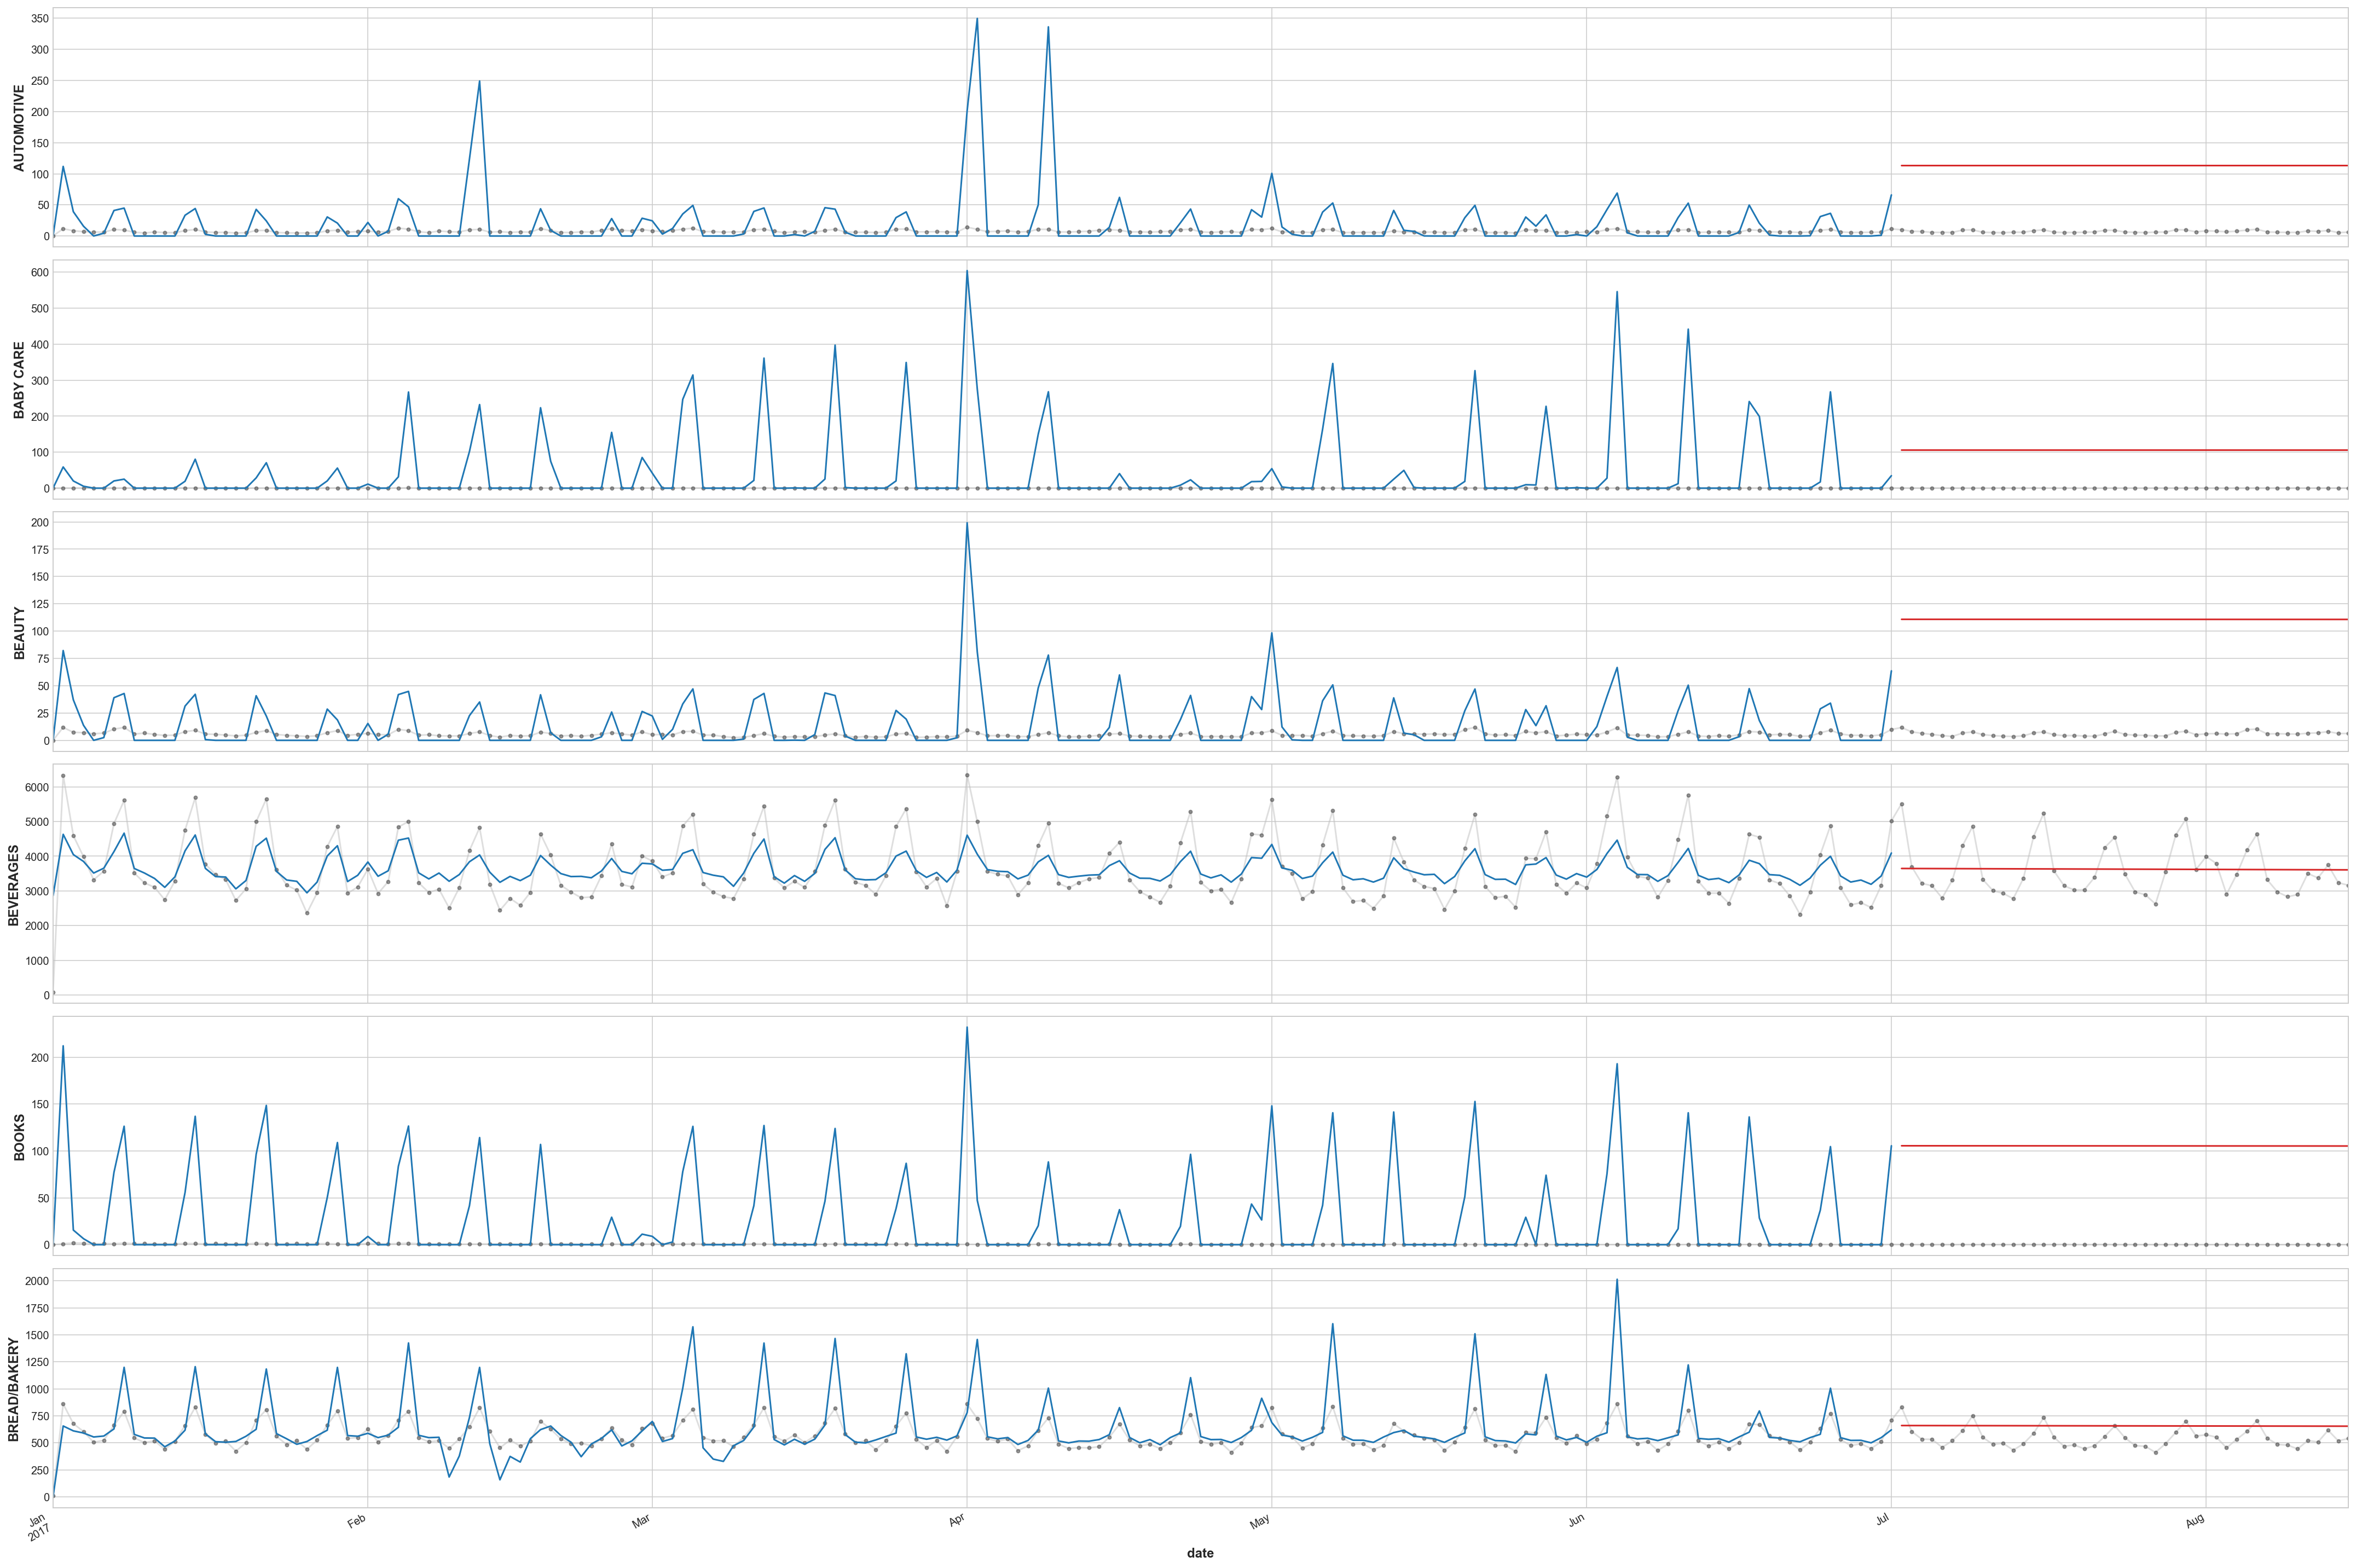

In [47]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(subplots=True, 
                                   sharex=True, 
                                   figsize=(30, 20), 
                                   color="0.75",
                                   style=".-",
                                   markeredgecolor="0.25",
                                   markerfacecolor="0.25",
                                   alpha=0.5)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

## Machine Learning Forecasting

In [48]:
# train data
store_sales = train.copy()
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

In [49]:
# test data

test = test.copy()
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [50]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

In [51]:
y = family_sales.loc[:, 'sales']

# make 4 lag features
X = make_lags(y, lags=5).dropna()

# make multistep target
y = make_multistep_target(y, steps=16).dropna()

y, X = y.align(X, join='inner', axis=0)

In [52]:
#prepare data for XGBoost
le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

display(y) 


y_step_1     y_step_2     y_step_3  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     6.132075    10.452830     9.566038   
           BABY CARE                      0.357143     0.333333     0.309524   
           BEAUTY                         6.641509    10.226415    11.830189   
           BEVERAGES                   3573.452830  4940.000000  5607.490566   
           BOOKS                          1.115385     1.000000     1.500000   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955648   403.601334   377.313980   
           PREPARED FOODS                84.698648    87.836796    88.735963   
           PRODUCE                     2257.140589  2609.180150  3122.895724   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333333    57.481481   
           SEAFOOD                       20.488333    20.346852    20.801037   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     6.056604     4.867925     6.433962   
           BABY CARE                      0.571429     0.309524     0.357143   
           BEAUTY                         5.754717     6.622642     5.377358   
           BEVERAGES                   3513.264151  3231.584906  3104.358491   
           BOOKS                          1.038462     1.076923     1.000000   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436093   533.497054   416.454018   
           PREPARED FOODS                77.173000    91.886760   100.384963   
           PRODUCE                     1792.220910  2079.319469  2418.970157   
           SCHOOL AND OFFICE SUPPLIES    51.907407    63.222222    85.203704   
           SEAFOOD                       17.116296    25.553963    24.209519   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     5.490566     5.339623     8.660377   
           BABY CARE                      0.380952     0.380952     0.500000   
           BEAUTY                         4.452830     4.792453     7.924528   
           BEVERAGES                   2744.547170  3286.905660  4755.358491   
           BOOKS                          0.807692     0.923077     1.192308   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596558   344.051740   313.780869   
           PREPARED FOODS               102.248148    86.627444    77.344130   
           PRODUCE                     2675.105815  2111.133423  2168.535465   
           SCHOOL AND OFFICE SUPPLIES   100.277778    64.407407    59.759259   
           SEAFOOD                       23.512852    18.419852    18.481130   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2017-01-06 AUTOMOTIVE                    10.452830     6.528302     5.792453   
           BABY CARE                      0.547619     0.404762     0.214286   
           BEAUTY                         9.207547     5.754717     5.452830   
           BEVERAGES                   5685.905660  3770.188679  3474.132075   
           BOOKS                          1.153846     0.807692     1.038462   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      305.270204   278.819870   468.857370   
           PREPARED FOODS                84.796537    78.791444    96.286926   
           PRODUCE                     2663.076241  1670.264889  2198.854500   
           SCHOOL AND OFFICE SUPPLIES  

## Forecast with DirRec Strategy

Instantiate a model that applies the DirRec Strategy to XGBoost

In [53]:
# init model
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import RegressorChain
model = RegressorChain(base_estimator=XGBRegressor())

In [54]:
# train model
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=y.index,columns=y.columns).clip(0.0)

In [55]:
# helpful function
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

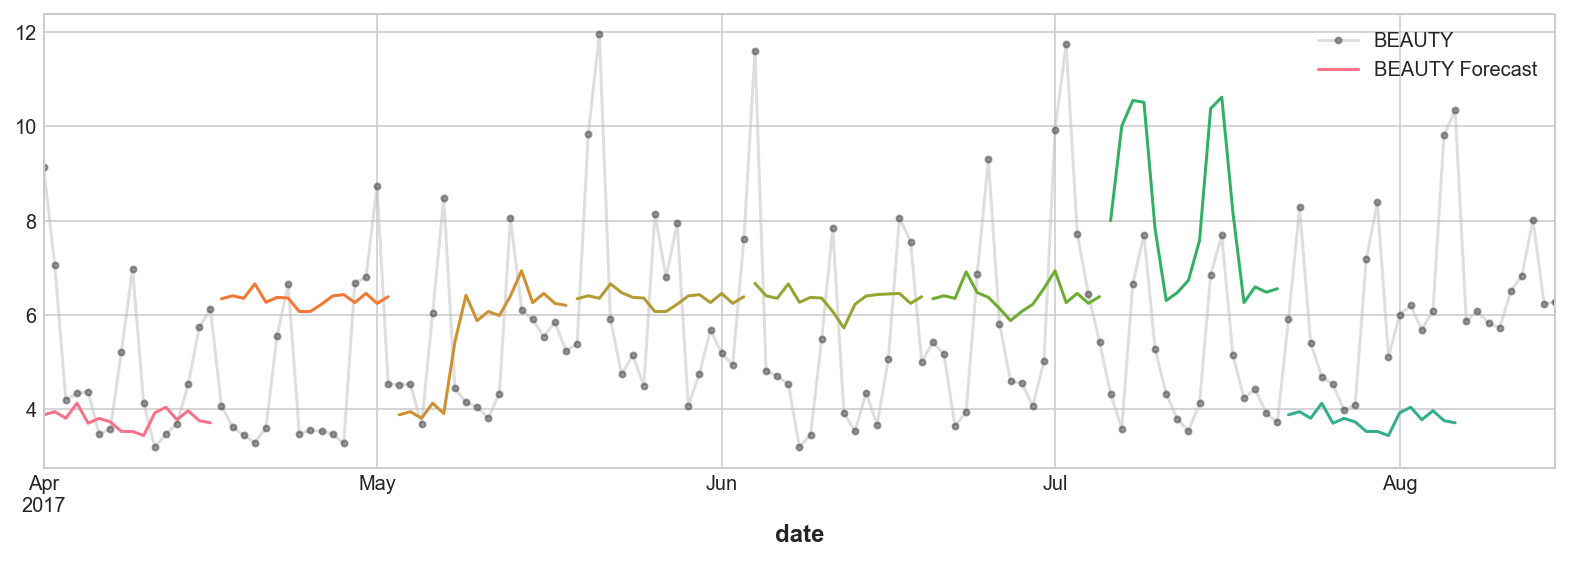

In [56]:
FAMILY = 'BEAUTY'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(color="0.75",style=".-",markeredgecolor="0.25", markerfacecolor="0.25",ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])